In [ ]:
path="/kaggle/input/kidneykits19/PNG_Slices_Segmented/PNG_Slices_Segmented/"

In [ ]:
import os
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision,Accuracy

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
H=256
W=256
dim=(H,W)

# DATA LOADING AND PROCESSING without any feature

In [ ]:
def load_data(file_path):
    #Loading the image files
    images = sorted(glob(f"{file_path}/*/Images/*.png"))
    segmentations=sorted(glob(f"{file_path}/*/Segmentation/*.png"))
    print(len(images),len(segmentations))


  # #Spliting the data into training and testing using builtin libraries
    split=0.3
    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(segmentations, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y)
 


def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x=cv2.resize(x, dim)
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x=cv2.resize(x, dim)
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset


In [ ]:
(train_x, train_y), (valid_x, valid_y) = load_data(path)
print(len(train_x),len(train_y))
print(len(valid_x),len(valid_y))
train_x, train_y = shuffling(train_x, train_y)



45079 45079
31556 31556
13523 13523


In [ ]:
batch_size = 32
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

# DEFINING METRICES

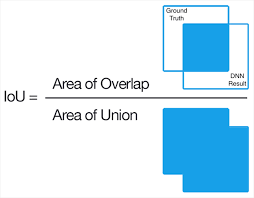

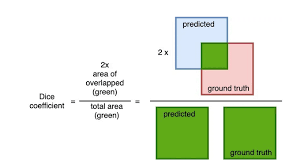

In [ ]:
#Metrices
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2.0 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# BUILDING UNET MODEL

In [ ]:
#Defining the structure of the model

#This convolution part will also be included in encoder and decoder part of the network
def Conv_Block(input,num_of_filter):
    x=Conv2D(num_of_filter,3,padding="same")(input)
    x=BatchNormalization()(x)
    x=Activation('ReLU')(x)

    x=Conv2D(num_of_filter,3,padding="same")(input)
    x=BatchNormalization()(x)
    x=Activation('ReLU')(x)
    return x


def Encoder(input,num_of_filter):
    x = Conv_Block(input, num_of_filter) #Skip connection
    p = MaxPool2D((2, 2))(x)  #Feature selection
    return x, p

def Decoder(input, skip_features, num_of_filter):
    x = Conv2DTranspose(num_of_filter, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = Conv_Block(x, num_of_filter)
    return x



def UNET_Build(input_shape):
    inputs=Input(input_shape)

  #as you go down in the encoder,resolution decreases , number of filters doubles
    s1,p1=Encoder(inputs,32)
    s2,p2=Encoder(p1,64)
    s3,p3=Encoder(p2,128)
    s4,p4=Encoder(p3,256)

    b1=Conv_Block(p4,512)

    d1 = Decoder(b1, s4, 256)
    d2 = Decoder(d1, s3, 128)
    d3 = Decoder(d2, s2, 64)
    d4 = Decoder(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #our data is in grayscale, gives 0,1 output

    model = Model(inputs, outputs, name="U-Net")
    return model  

In [ ]:
input_shape = (256, 256, 3)
model = UNET_Build(input_shape)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

# MODEL TRAINING

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
batch_size = 32
lr = 0.01
num_epochs = 15

In [ ]:
model = UNET_Build((H, W, 3))
metrics = [dice_coef, iou, Recall(),Precision()]
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

In [ ]:
model_weights = "/kaggle/working/model_UNET.h5"
csv_weights = "/kaggle/working/datamodel1.csv"

callbacks = [
    ModelCheckpoint( model_weights,verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.00001, patience=2, min_lr=1e-7, verbose=1),
    TensorBoard(),
    CSVLogger(csv_weights),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=False),
    ]

In [ ]:
with tf.device('/GPU:0'):
    model.fit(train_dataset,epochs=num_epochs,validation_data=valid_dataset,callbacks=callbacks,shuffle=False )

Epoch 1/15
987/987 [==============================] - 819s 819ms/step - loss: 0.2709 - dice_coef: 0.7293 - iou: 0.5974 - recall: 0.7190 - precision: 0.4766 - val_loss: 0.9552 - val_dice_coef: 0.0447 - val_iou: 0.0235 - val_recall: 0.0228 - val_precision: 0.9946

Epoch 00001: val_loss improved from inf to 0.95523, saving model to /kaggle/working/model_UNET.h5
Epoch 2/15
987/987 [==============================] - 405s 411ms/step - loss: 0.0965 - dice_coef: 0.9036 - iou: 0.8278 - recall: 0.8786 - precision: 0.9320 - val_loss: 0.0643 - val_dice_coef: 0.9357 - val_iou: 0.8807 - val_recall: 0.9378 - val_precision: 0.9366

Epoch 00002: val_loss improved from 0.95523 to 0.06432, saving model to /kaggle/working/model_UNET.h5
Epoch 3/15
987/987 [==============================] - 413s 419ms/step - loss: 0.0581 - dice_coef: 0.9419 - iou: 0.8919 - recall: 0.9311 - precision: 0.9556 - val_loss: 0.1901 - val_dice_coef: 0.8099 - val_iou: 0.6842 - val_recall: 0.7731 - val_precision: 0.8540

Epoch 00003

In [ ]:
# os.remove("/kaggle/working/model_UNET.h5")

In [ ]:

os.chdir(r'/kaggle/working')
from IPython.display import FileLink

# FileLink(r'model.h5')
FileLink(r'data_model1.csv')

/kaggle/working/data_model1.csv